<a href="https://colab.research.google.com/github/Yash-10/Higgs-Classification/blob/main/BDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gzip -d HIGGS.csv.gz
!rm -f HIGGS.csv.gz

--2021-06-10 17:51:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  45.0MB/s    in 61s     

2021-06-10 17:52:30 (43.9 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [4]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
"""
Description:
------------
- 21 low-level features, 7 high level features
- Low-level features > Kinematic properties measured by particle detectors in the accelerator.
- High-level features > Are a function of low-level features.

"""
d = pd.read_csv('HIGGS.csv', header=None, nrows=11000000*0.1)

In [6]:
col_names = "label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb"
cols = col_names.split(",")
cols = list(map(lambda name: name.strip(), cols))

d.columns = cols

In [7]:
d # 1: signal, 0: background

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.0,1.147101,-0.290297,-0.502390,0.787117,-0.115922,1.501992,-0.961539,-0.940719,2.173076,1.233225,0.305072,0.820493,0.000000,0.956083,-0.661578,0.884154,2.548224,1.816548,0.785724,1.255605,0.000000,0.971365,0.957792,0.987488,0.941613,1.499944,1.521772,1.303628
1099996,1.0,1.078290,0.090525,-1.113295,0.828900,0.153260,1.389315,-0.565447,0.124895,0.000000,1.785437,0.242904,-1.478273,0.000000,1.601667,-0.563271,0.606786,2.548224,0.977036,0.542540,-1.517396,0.000000,0.352488,0.508641,1.191143,1.010111,0.888589,0.931572,0.859181
1099997,1.0,0.915960,0.174286,-0.096232,1.543762,0.596144,0.664335,-0.476326,-1.245072,1.086538,0.457407,0.424551,-1.203077,0.000000,0.816815,0.539040,1.717921,0.000000,0.687625,-0.108728,0.350543,3.101961,0.462586,0.593328,0.988834,1.154577,0.720061,0.737488,0.683846
1099998,1.0,0.585263,-0.882470,-1.682583,0.990881,0.796417,1.032413,-0.100039,-0.312609,0.000000,1.306123,-1.995141,1.145623,0.000000,1.465560,0.391580,-1.617808,2.548224,1.435372,-0.585103,0.029249,0.000000,0.800382,0.917762,0.982345,0.820718,0.939589,0.953103,0.852331


In [65]:
print(f"Signal instances: {len(d[d['label'] == 1.0])}")
print(f"Background instances: {len(d[d['label'] == 0.0])}")

Signal instances: 582469
Background instances: 517531


In [8]:
# Ensure all types are `float` and not `object`
d.dtypes

label                       float64
lepton pT                   float64
lepton eta                  float64
lepton phi                  float64
missing energy magnitude    float64
missing energy phi          float64
jet 1 pt                    float64
jet 1 eta                   float64
jet 1 phi                   float64
jet 1 b-tag                 float64
jet 2 pt                    float64
jet 2 eta                   float64
jet 2 phi                   float64
jet 2 b-tag                 float64
jet 3 pt                    float64
jet 3 eta                   float64
jet 3 phi                   float64
jet 3 b-tag                 float64
jet 4 pt                    float64
jet 4 eta                   float64
jet 4 phi                   float64
jet 4 b-tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       

In [9]:
d = d.sample(frac=1).reset_index(drop=True)  # Shuffle

In [10]:
d["label"] = d.label.astype("category")

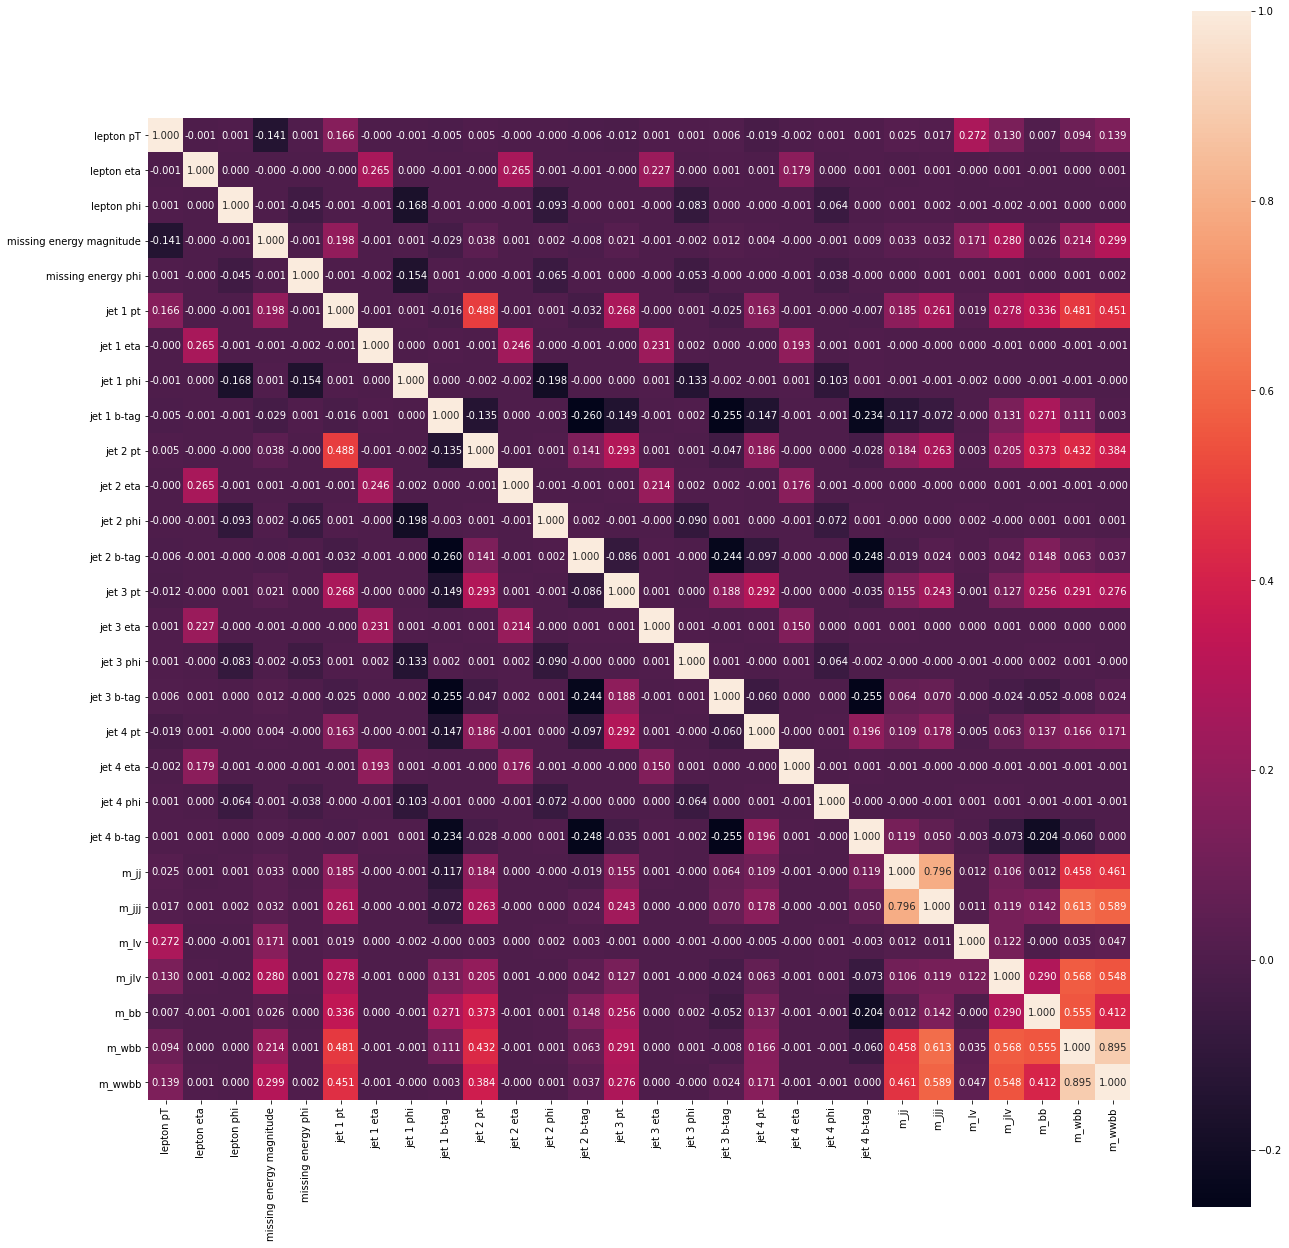

In [21]:
fig = plt.figure(figsize=(22, 22))
sns.heatmap(d.corr(), annot=True, square=True, fmt=".3f");

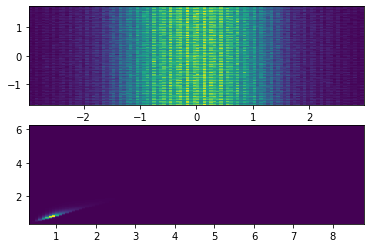

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, )

counts, xedges, yedges, im = ax1.hist2d(d["jet 1 eta"], d["jet 1 phi"], bins=100)
counts, xedges, yedges, im = ax2.hist2d(d["m_wbb"], d["m_wwbb"], bins=100)

In [24]:
d.isnull().values.any() # Check if any null values in the dataset

False

In [26]:
def prepare_df(df, which_feats="full"):
  """Returns a new dataset with only the required features.

  Parameters:
  -----------
  df: ~pd.DataFrame
    Dataset, as is.
  which_feats: ~str
    Which features to use for training the model, defaults to "full".
    Other options: "high_level", or "low_level".
  
  Returns:
  --------
  new_df: The dataset with the required features.

  """
  cols = list(df.columns)
  cols = list(map(lambda name: name.strip(), cols))
  if which_feats == "low_level":
    return df[["label"] + cols[1:22]]
  elif which_feats == "high_level":
    return df[["label"] + cols[22:]]
  else:
    return df

In [27]:
df = prepare_df(d, which_feats="low_level")

In [28]:
num_rows = len(df.index)
train_df = df[:int(0.7*num_rows)]
test_df = df[int(0.7*num_rows):]

In [29]:
import xgboost as xgb

In [30]:
feature_names = df.columns[1:]
train = xgb.DMatrix(data=train_df[feature_names], label=train_df.label.cat.codes,
                    feature_names=feature_names)
test = xgb.DMatrix(data=test_df[feature_names], label=test_df.label.cat.codes,
                   feature_names=feature_names)

In [31]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [32]:
booster = xgb.train(param, train, num_boost_round=num_trees)  # Execution time: 

In [39]:
booster.save_model(fname="/content/xgboost_train.txt")

In [33]:
print(booster.eval(test))

[0]	eval-error:0.331858	eval-logloss:0.605219	eval-rmse:0.457590


In [34]:
predictions = booster.predict(test)

In [40]:
predictions

array([0.3995972 , 0.6667425 , 0.96508306, ..., 0.5566613 , 0.6925488 ,
       0.41550604], dtype=float32)

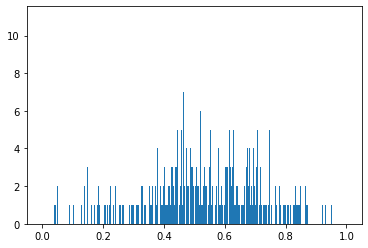

In [52]:
plt.hist(predictions, bins=np.linspace(0, 1, len(predictions)));

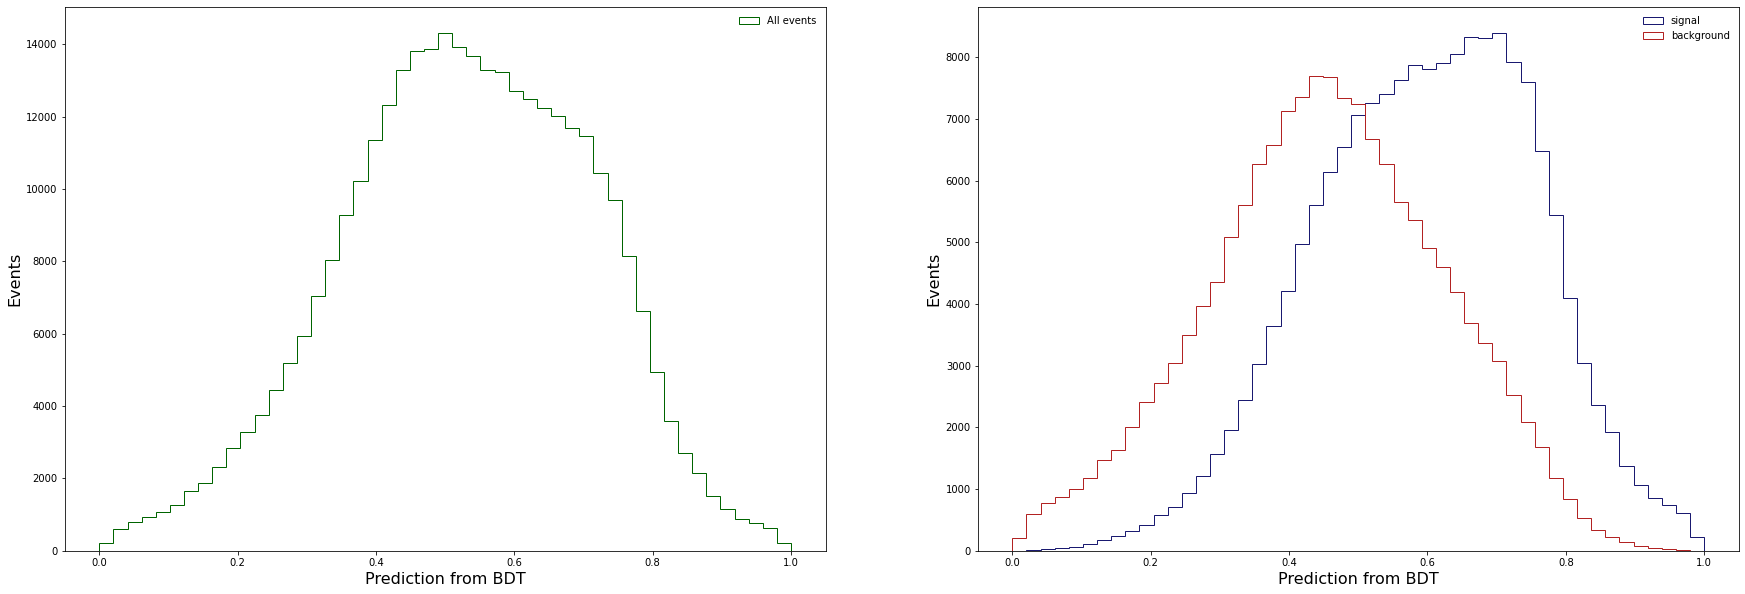

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10));

hist_style_all = dict(histtype="step", color="darkgreen", label="All events")
hist_style_sig = dict(histtype="step", color="midnightblue", label="signal")
hist_style_bkg = dict(histtype="step", color="firebrick", label="background")

ax1.hist(predictions, bins=np.linspace(0, 1, 50), **hist_style_all);

ax1.set_xlabel("Prediction from BDT", fontsize=16);
ax1.set_ylabel("Events", fontsize=16);
ax1.legend(frameon=False);

ax2.hist(predictions[test.get_label().astype(bool)], bins=np.linspace(0, 1, 50),
         **hist_style_sig);
ax2.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         **hist_style_bkg);

ax2.set_xlabel("Prediction from BDT", fontsize=16);
ax2.set_ylabel("Events", fontsize=16);
ax2.legend(frameon=False);

In [88]:
!pip install plot-metric

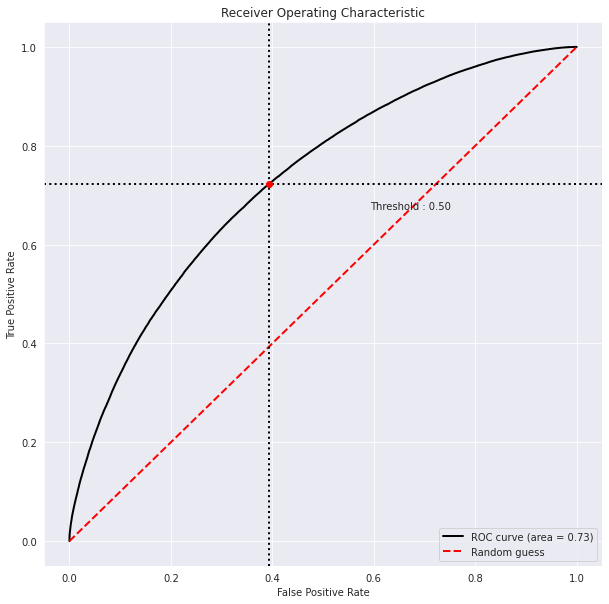

In [89]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(test.get_label(), predictions, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()

**AUC = 0.73**

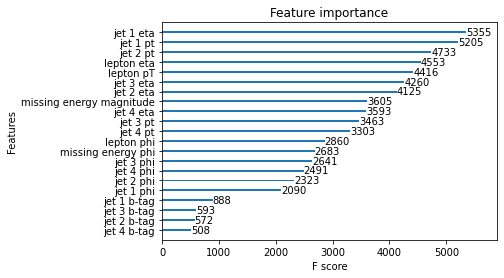

In [81]:
xgb.plot_importance(booster, grid=False);

`jet 1 eta` has the highest F1-score and is the most important feature.